In [2]:
import numpy as np
import pandas as pd
import torch
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import f1_score

import numpy as np
from datetime import datetime

In [ ]:
# API Hogwash
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

# Downloading the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

#Extract the zipfile that is just downloaded. This may take a while.
import zipfile

with zipfile.ZipFile("chest-xray-pneumonia.zip","r") as z:
  z.extractall(".")

kaggle.json
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls
# mainDIR = os.listdir('chest_xray')
# print(mainDIR)

chest_xray		  ConfusionMatrix.png  sample_data
chest-xray-pneumonia.zip  kaggle.json


In [ ]:
train_folder= 'chest_xray/train/'
val_folder = 'chest_xray/val/'
test_folder = 'chest_xray/test/'

#labelling: n=normal, p=pneumonia

train_n = train_folder+'NORMAL/'
train_p = train_folder+'PNEUMONIA/'

test_n = test_folder+'NORMAL/'
test_p = test_folder+'PNEUMONIA/'

val_n = val_folder+'NORMAL/'
val_p = val_folder+'PNEUMONIA/'

In [ ]:
datasets = ["train", "test", "val"]
labels = ["_n", "_p"]

for dataset in datasets:
  print(f"{dataset} size")
  for label in labels:
    print(f"\t{dataset+label}:{len(os.listdir(locals()[dataset+label]))}")

train size
	train_n:1341
	train_p:3875
test size
	test_n:234
	test_p:390
val size
	val_n:8
	val_p:8


### Hyperparameters

In [ ]:
BATCH_SIZE = 32
RANDOM_SEED = 42
IMG_RESIZE = 230         # Shortest side of images post-resizing (pre-center-cropping to 224)
# IMG_CHANNEL_MEAN = 0.5   # Normalized mean of image tensors
# IMG_CHANNEL_STD = 0.5    # Normalized std of image tensors
LEARNING_RATE = 0.001
VALID_SIZE = 500         # Number of images in given training set to use for validation set
# BATCH_SIZE = 16
N_EPOCHS = 12
N_CLASSES = 2

### Data Processing

In [ ]:
# https://stackoverflow.com/questions/67799246/weighted-random-sampler-oversample-or-undersample
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight                        

In [ ]:
class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.imgs = [subset.dataset.imgs[i] for i in subset.indices]
        self.classes = subset.dataset.classes

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [ ]:
torch.manual_seed(RANDOM_SEED)

# Define the transformer
train_transformer = transforms.Compose([#transforms.Grayscale(num_output_channels=1),
                                        transforms.RandomRotation(10),
                                        transforms.RandomEqualize(),
                                        transforms.Resize(IMG_RESIZE),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                      ])
test_transformer = transforms.Compose([#transforms.Grayscale(num_output_channels=1),
                                       transforms.Resize(IMG_RESIZE),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                      ])

# Read the training and validation datasets from their respective folders
dataset = ImageFolder(root=train_folder)

# So a stratified subsampling of the training images to get our training and validation sets
# https://linuxtut.com/en/c6023453e00bfead9e9f/
train_indices, valid_indices = train_test_split(list(range(len(dataset.targets))), test_size=0.1, stratify=dataset.targets)
train_dataset = DatasetFromSubset(Subset(dataset, train_indices), transform=train_transformer)
valid_dataset = DatasetFromSubset(Subset(dataset, valid_indices), transform=test_transformer)

# Compute the class weights in both sets (should be similar after train_test_split)
train_weights = torch.DoubleTensor(make_weights_for_balanced_classes(train_dataset.imgs, len(train_dataset.classes)))
valid_weights = torch.DoubleTensor(make_weights_for_balanced_classes(valid_dataset.imgs, len(valid_dataset.classes)))

# Create the training and validation DataLoaders, with a WeightedRandomSampler to account for class imbalance
# Shout out to Janine for saying to use .dataset attribute
# (https://discuss.pytorch.org/t/how-to-iterate-subset-after-random-split-typeerror-dataloader-object-is-not-subscriptable/73933/3)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, pin_memory=True, sampler=WeightedRandomSampler(train_weights, len(train_weights), generator=torch.Generator().manual_seed(RANDOM_SEED)))
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, pin_memory=True, sampler=WeightedRandomSampler(valid_weights, len(valid_weights), generator=torch.Generator().manual_seed(RANDOM_SEED)))

dataset = train_imgs
trainset = train_dataset
validset = valid_dataset
trainloader = train_loader
validloader = valid_loader

### Helper Functions

In [ ]:
# Helper Functions

def train(train_loader, model, criterion, optimizer, device):
  '''
  Function for the training step of the training loop
  '''
  model.train()
  running_loss = 0

  for X, y_true in train_loader:

    optimizer.zero_grad()

    X = X.to(device)
    y_true = y_true.to(device)

    # Forward Pass - Get predictions for the batch using the current weights
    y_hat = model(X)

    # Calculate the value of the loss function
    loss = criterion(y_hat, y_true)
    running_loss += loss.item() * X.size(0)

    # Backward Pass - Adjust weights based on the loss
    loss.backward()
    optimizer.step()

  epoch_loss = running_loss / len(train_loader.dataset)
  return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
  '''
  Function for the validation step of the training loop
  '''

  model.eval()
  running_loss = 0

  for X, y_true in valid_loader:

    X = X.to(device)
    y_true = y_true.to(device)

    # Forward Pass
    y_hat = model(X)

    loss = criterion(y_hat, y_true)
    running_loss += loss.item() * X.size(0)

  epoch_loss = running_loss / len(valid_loader.dataset)
  return model, epoch_loss


def get_accuracy(model, data_loader, device):
  '''
  Function for computing the accuracy of the predictions over the entire data_loader
  '''
  correct_pred = 0
  n = 0

  with torch.no_grad():
    model.eval()
    for X, y_true in data_loader:

      X = X.to(device)
      y_true = y_true.to(device)

      y_prob = model(X)
      _, predicted_labels = torch.max(y_prob, 1)

      n += y_true.size(0)
      correct_pred += (predicted_labels == y_true).sum()

      yTrue = copy.deepcopy(y_true)
      predictedLabels = copy.deepcopy(predicted_labels)

    acc = correct_pred.float() / n


    #   def accuracy(outputs, labels):
    # _, preds = torch.max(outputs, dim=1) 
    # return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

  return acc

def plot_losses(train_losses, valid_losses):
  '''
  Function for plotting training and validation losses
  '''

  plt.style.use('seaborn')

  train_losses = np.array(train_losses)
  valid_losses = np.array(valid_losses)

  fig, ax = plt.subplots(figsize = (8, 4.5))

  ax.plot(train_losses, color='blue', label='Training loss') 
  ax.plot(valid_losses, color='red', label='Validation loss')
  ax.set(title="Loss over epochs", 
         xlabel='Epoch',
         ylabel='Loss') 
  ax.legend()
  fig.show()
  
  # change the plot style to default
  plt.style.use('default')


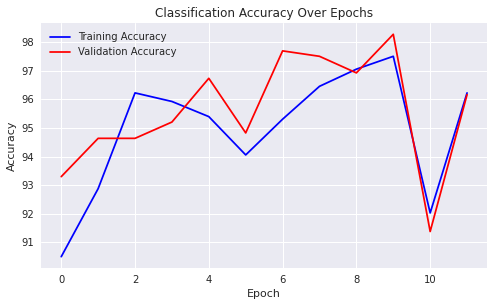

In [3]:
'''
Function for plotting training and validation losses
'''

plt.style.use('seaborn')

train_accs = np.array([90.5,92.88,96.23,95.93,95.4,94.06,95.31,96.46,97.06,97.51,92.03,96.23])
valid_accs = np.array([93.3,94.64,94.64,95.21,96.74,94.83,97.7,97.51,96.93,98.28,91.38,96.17])

fig, ax = plt.subplots(figsize = (8, 4.5))

ax.plot(train_accs, color='blue', label='Training Accuracy')
ax.plot(valid_accs, color='red', label='Validation Accuracy')
ax.set(title="Classification Accuracy Over Epochs", 
        xlabel='Epoch',
        ylabel='Accuracy') 
ax.legend()
fig.show()

# change the plot style to default
plt.style.use('default')

### Training

In [ ]:
# Main Training Loop

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
  '''
  Function defining the entire training loop
  '''

  # Set objects for storing metrics
  best_loss = 1e10
  train_losses = []
  valid_losses = []

  # Training Loop
  for epoch in range(epochs):

    # Training Step
    model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
    train_losses.append(train_loss)

    # Validation Step
    with torch.no_grad():
      model, valid_loss = validate(valid_loader, model, criterion, device)
      valid_losses.append(valid_loss)

    if epoch % print_every == (print_every - 1):

      train_acc = get_accuracy(model, train_loader, device=device)
      valid_acc = get_accuracy(model, valid_loader, device=device)

      print(f'{datetime.now().time().replace(microsecond=0)} --- '
            f'Epoch: {epoch}\t'
            f'Train loss: {train_loss:.4f}\t'
            f'Valid loss: {valid_loss:.4f}\t'
            f'Train accuracy: {100 * train_acc:.2f}\t'
            f'Valid accuracy: {100 * valid_acc:.2f}')
    
  plot_losses(train_losses, valid_losses)

  return model, optimizer, (train_losses, valid_losses)

### ALEXNET

In [ ]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
alex = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
alex.to(DEVICE)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import accuracy_score

epochs = 12
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alex.parameters(), lr =learning_rate)

00:36:37 --- Epoch: 0	Train loss: 0.7437	Valid loss: 0.1739	Train accuracy: 90.50	Valid accuracy: 93.30
00:42:51 --- Epoch: 1	Train loss: 0.2946	Valid loss: 0.1589	Train accuracy: 92.88	Valid accuracy: 94.64
00:49:05 --- Epoch: 2	Train loss: 0.2271	Valid loss: 0.1438	Train accuracy: 96.23	Valid accuracy: 94.64
00:55:18 --- Epoch: 3	Train loss: 0.1716	Valid loss: 0.0568	Train accuracy: 95.93	Valid accuracy: 95.21
01:01:34 --- Epoch: 4	Train loss: 0.2342	Valid loss: 0.1356	Train accuracy: 95.40	Valid accuracy: 96.74
01:07:51 --- Epoch: 5	Train loss: 0.1679	Valid loss: 0.1454	Train accuracy: 94.06	Valid accuracy: 94.83
01:14:10 --- Epoch: 6	Train loss: 0.1516	Valid loss: 0.0844	Train accuracy: 95.31	Valid accuracy: 97.70
01:20:28 --- Epoch: 7	Train loss: 0.1184	Valid loss: 0.0544	Train accuracy: 96.46	Valid accuracy: 97.51
01:26:44 --- Epoch: 8	Train loss: 0.1313	Valid loss: 0.1383	Train accuracy: 97.06	Valid accuracy: 96.93
01:32:56 --- Epoch: 9	Train loss: 0.0959	Valid loss: 0.0575	Trai

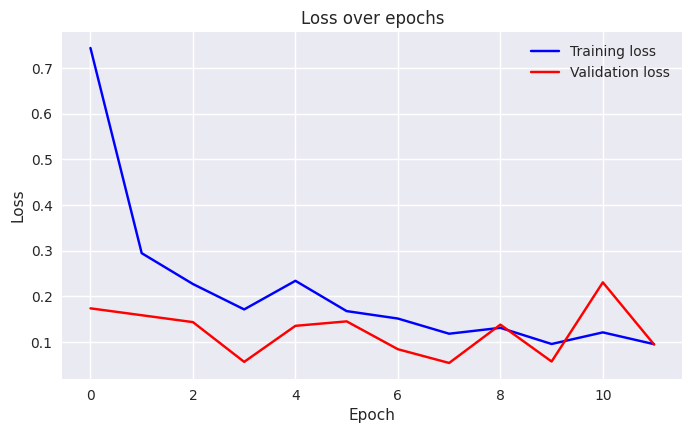

In [ ]:
import copy
model, optimizer, _ = training_loop(alex, criterion, optimizer, trainloader, validloader, epochs, DEVICE)

### Training Results

Accuracy: 0.945888368129527
Recall: 0.9291654717522225
Specificity: 0.9942004971002486
Precision: 0.9978441638435479
F1: 0.9622809622809623


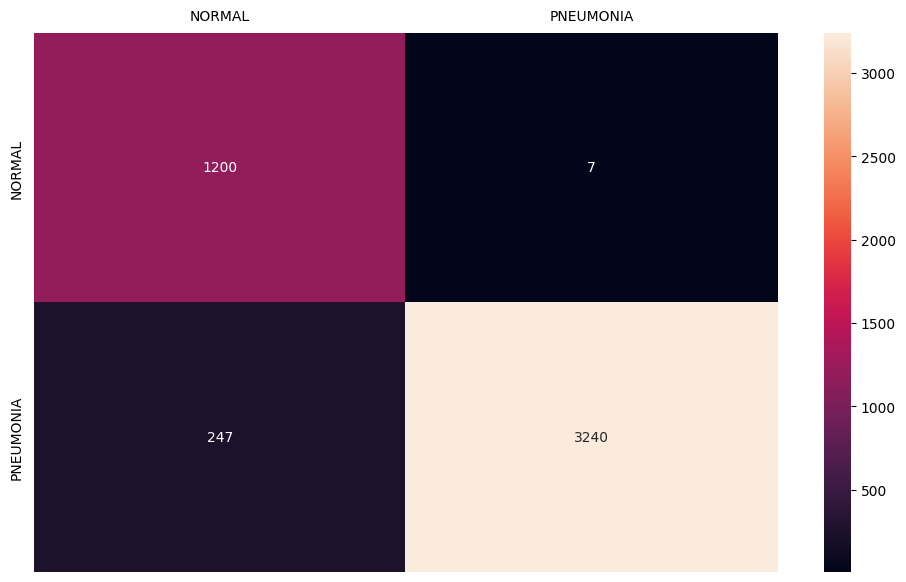

In [ ]:
# Adapted from https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd

# test_dataset = ImageFolder(root=test_folder, transform=preprocess)
test_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=False)

y_pred = []
y_true = []

with torch.no_grad():
  model.eval()

  for inputs, labels in test_loader:

    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    probs = model(inputs)
    _, output = torch.max(probs, 1)
    
    output = output.data.cpu().numpy()
    y_pred.extend(output)

    labels = labels.data.cpu().numpy()
    y_true.extend(labels)

classes = ('NORMAL', 'PNEUMONIA')

cf_matrix = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])

plt.figure(figsize=(12,7))
ax = sn.heatmap(df_cm, annot=True, fmt="d")
# ax.xaxis.tick_top()
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, left=False, labeltop=True)
ax.xaxis.set_label_position("top")
plt.savefig("ConfusionMatrix.png")

tp = cf_matrix[1][1]
fp = cf_matrix[0][1]
tn = cf_matrix[0][0]
fn = cf_matrix[1][0]
accuracy = (tp + tn)/(tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1 = 2 * precision * recall / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Specificity: {specificity}")
print(f"Precision: {precision}")
print(f"F1: {f1}")


### Testing Results

Accuracy: 0.8397435897435898
Precision: 0.8138528138528138
Recall: 0.9641025641025641
Specificity: 0.6324786324786325
F1: 0.8826291079812205


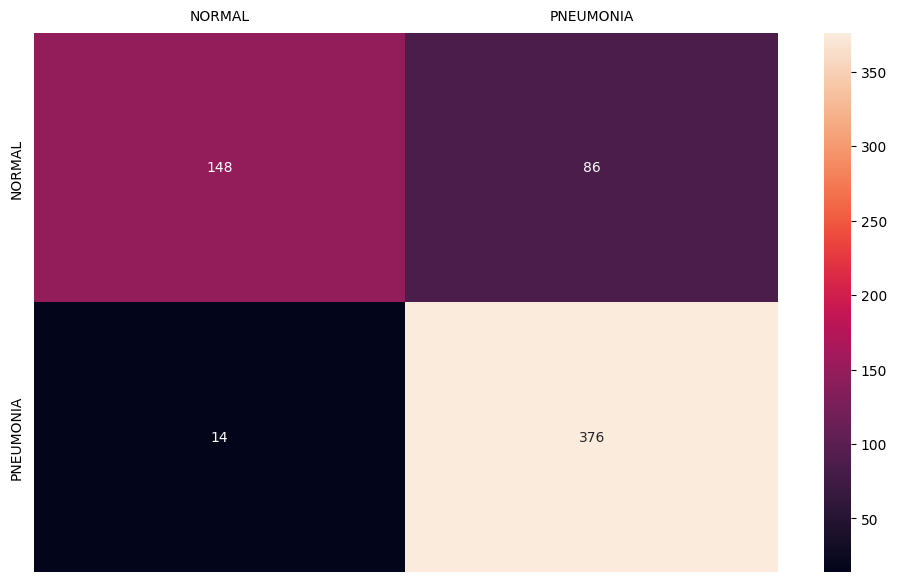

In [ ]:
# Adapted from https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd

test_dataset = ImageFolder(root=test_folder, transform=test_transformer)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

y_pred = []
y_true = []

with torch.no_grad():
  model.eval()

  for inputs, labels in test_loader:

    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    probs = model(inputs)
    _, output = torch.max(probs, 1)
    
    output = output.data.cpu().numpy()
    y_pred.extend(output)

    labels = labels.data.cpu().numpy()
    y_true.extend(labels)

classes = ('NORMAL', 'PNEUMONIA')

cf_matrix = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])

plt.figure(figsize=(12,7))
ax = sn.heatmap(df_cm, annot=True, fmt="d")
# ax.xaxis.tick_top()
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, left=False, labeltop=True)
ax.xaxis.set_label_position("top")
plt.savefig("ConfusionMatrix.png")

tp = cf_matrix[1][1]
fp = cf_matrix[0][1]
tn = cf_matrix[0][0]
fn = cf_matrix[1][0]
accuracy = (tp + tn)/(tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1 = 2 * precision * recall / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Specificity: {specificity}")
print(f"F1: {f1}")


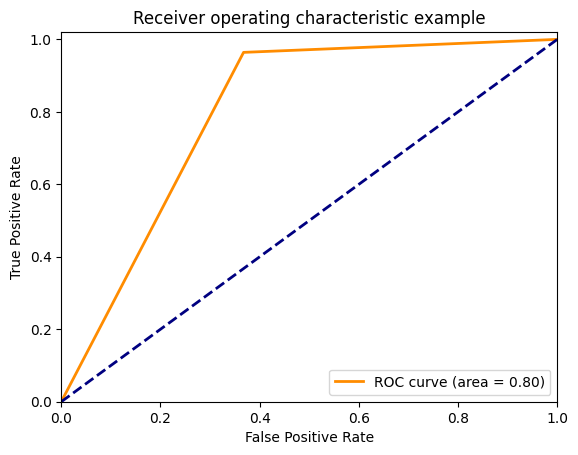

In [ ]:
# Adapted from https://discuss.pytorch.org/t/roc-curves-for-a-simple-cnn-multi-class-model/98069/2
from sklearn.metrics import roc_curve, auc, f1_score

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Validation Results

Accuracy: 0.9521072796934866
Recall: 0.9355670103092784
Specificity: 1.0
Precision: 1.0
F1: 0.966711051930759


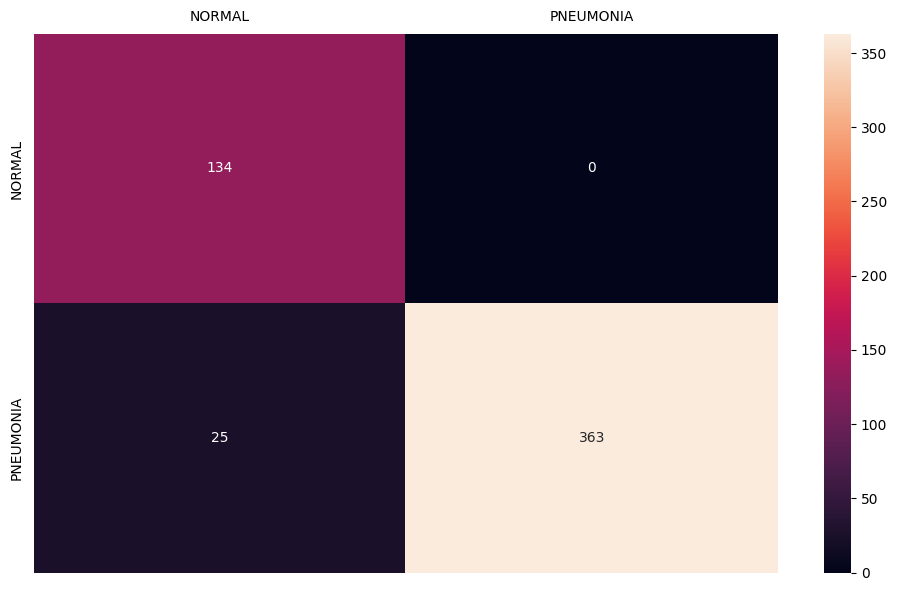

In [ ]:
# Adapted from https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd

# test_dataset = ImageFolder(root=test_folder, transform=preprocess)
test_loader = torch.utils.data.DataLoader(dataset=validset, batch_size=BATCH_SIZE, shuffle=False)

y_pred = []
y_true = []

with torch.no_grad():
  model.eval()

  for inputs, labels in test_loader:

    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    probs = model(inputs)
    _, output = torch.max(probs, 1)
    
    output = output.data.cpu().numpy()
    y_pred.extend(output)

    labels = labels.data.cpu().numpy()
    y_true.extend(labels)

classes = ('NORMAL', 'PNEUMONIA')

cf_matrix = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])

plt.figure(figsize=(12,7))
ax = sn.heatmap(df_cm, annot=True, fmt="d")
# ax.xaxis.tick_top()
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, left=False, labeltop=True)
ax.xaxis.set_label_position("top")
plt.savefig("ConfusionMatrix.png")

tp = cf_matrix[1][1]
fp = cf_matrix[0][1]
tn = cf_matrix[0][0]
fn = cf_matrix[1][0]
accuracy = (tp + tn)/(tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1 = 2 * precision * recall / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Specificity: {specificity}")
print(f"Precision: {precision}")
print(f"F1: {f1}")


Accuracy: 0.8397435897435898
Precision: 0.8138528138528138
Recall: 0.9641025641025641
Specificity: 0.6324786324786325
F1: 0.8826291079812205


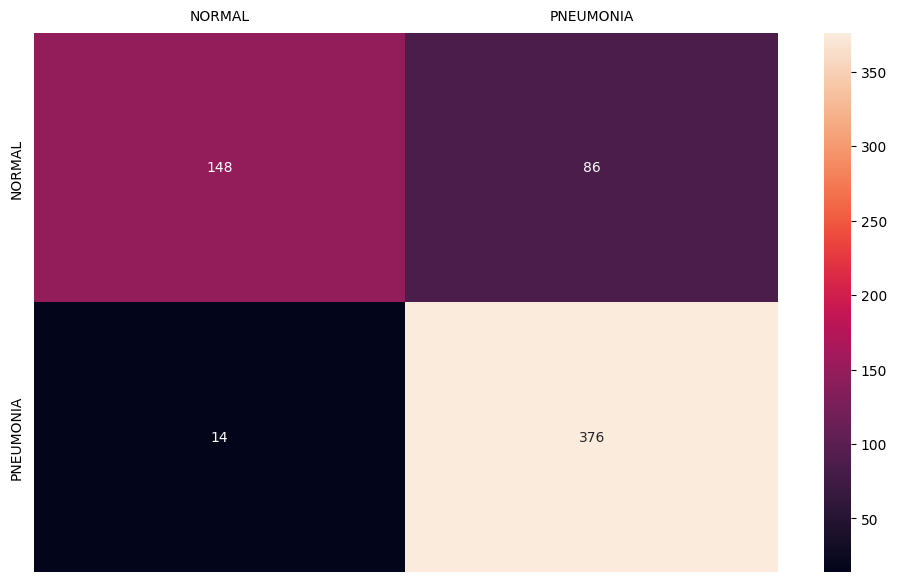

In [ ]:
# Adapted from https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd

test_dataset = ImageFolder(root=test_folder, transform=test_transformer)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

y_pred = []
y_true = []

with torch.no_grad():
  model.eval()

  for inputs, labels in test_loader:

    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    probs = model(inputs)
    _, output = torch.max(probs, 1)
    
    output = output.data.cpu().numpy()
    y_pred.extend(output)

    labels = labels.data.cpu().numpy()
    y_true.extend(labels)

classes = ('NORMAL', 'PNEUMONIA')

cf_matrix = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])

plt.figure(figsize=(12,7))
ax = sn.heatmap(df_cm, annot=True, fmt="d")
# ax.xaxis.tick_top()
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, left=False, labeltop=True)
ax.xaxis.set_label_position("top")
plt.savefig("ConfusionMatrix.png")

tp = cf_matrix[1][1]
fp = cf_matrix[0][1]
tn = cf_matrix[0][0]
fn = cf_matrix[1][0]
accuracy = (tp + tn)/(tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1 = 2 * precision * recall / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Specificity: {specificity}")
print(f"F1: {f1}")


100


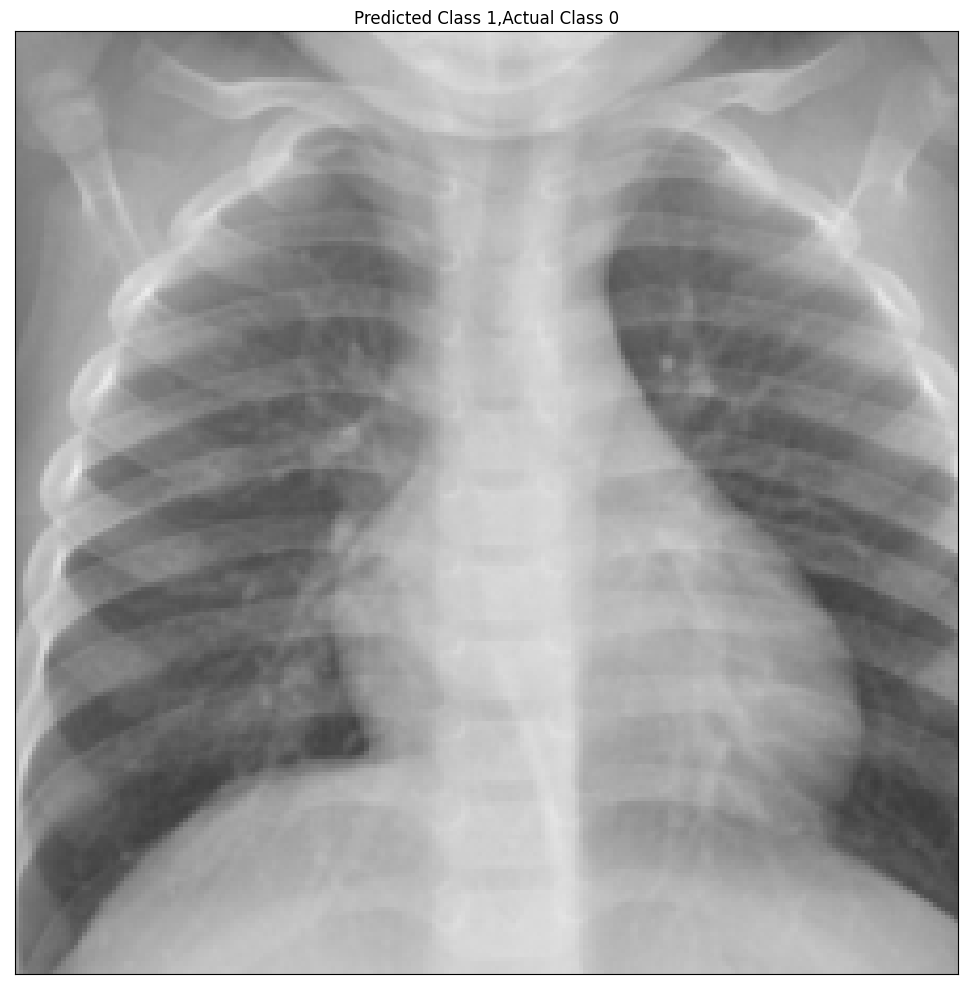

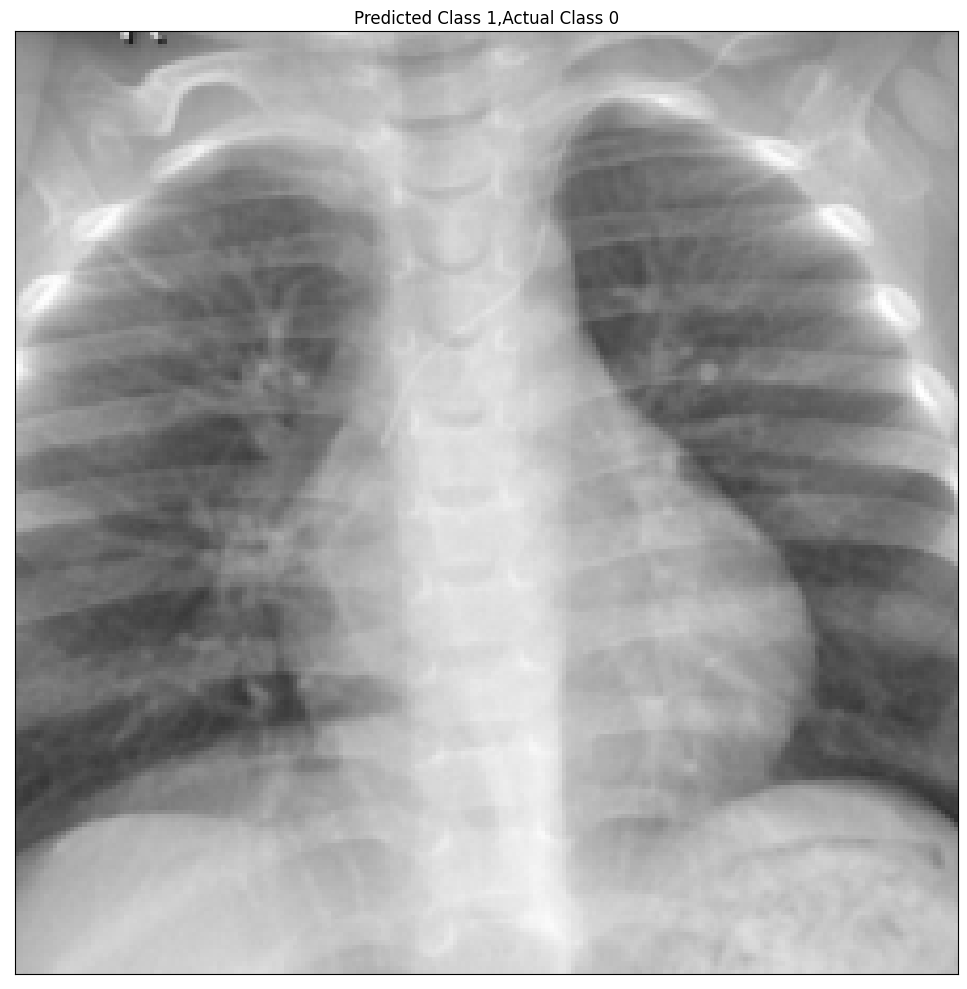

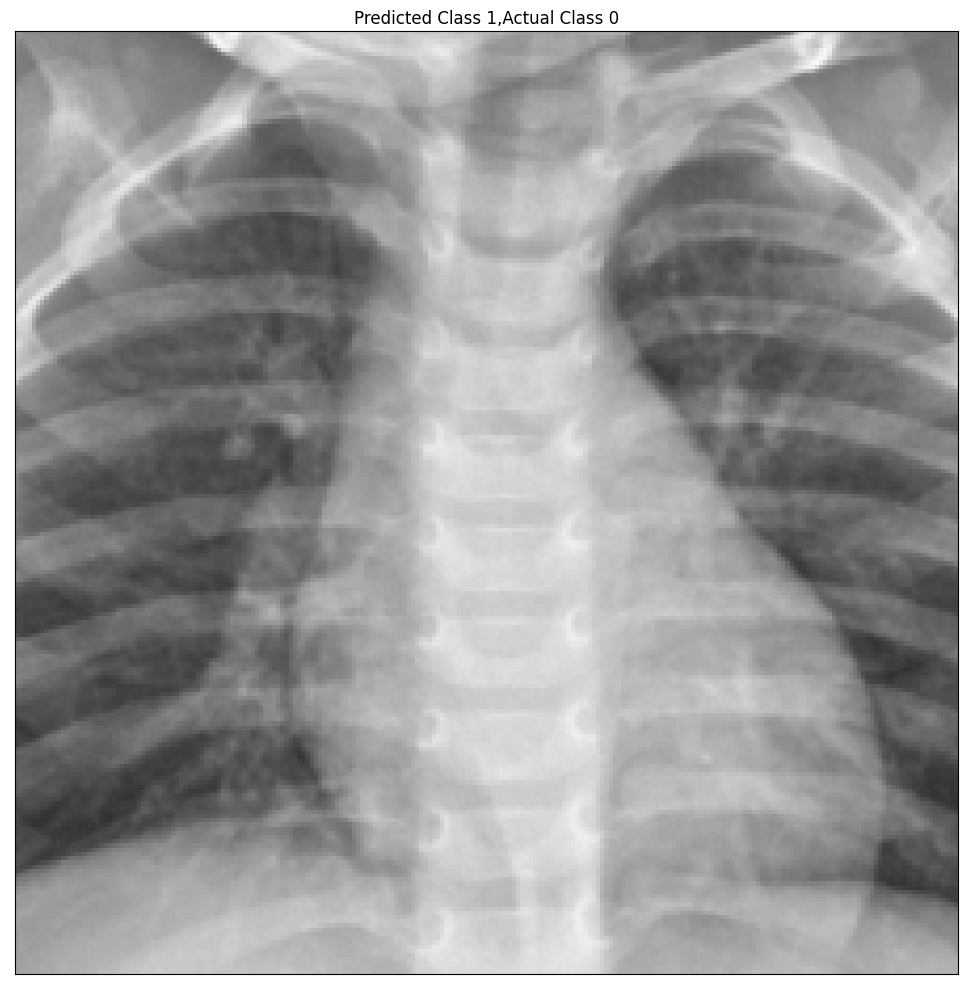

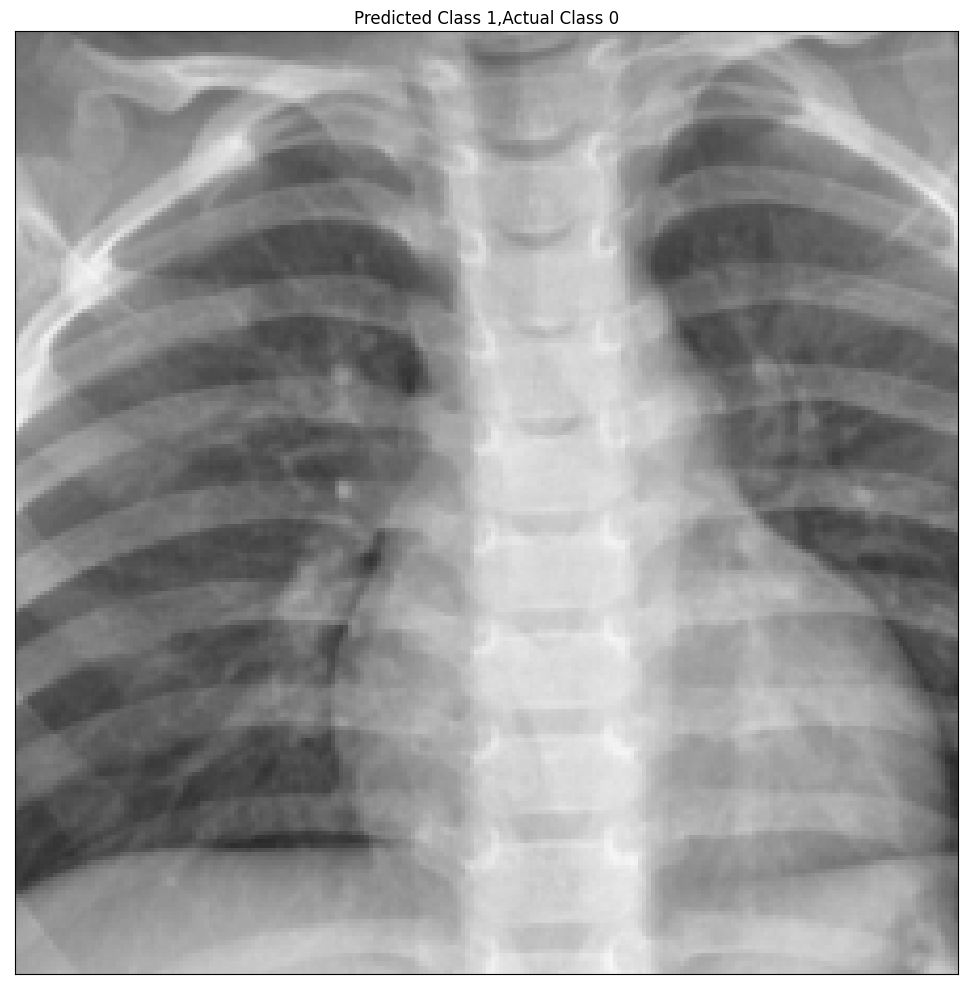

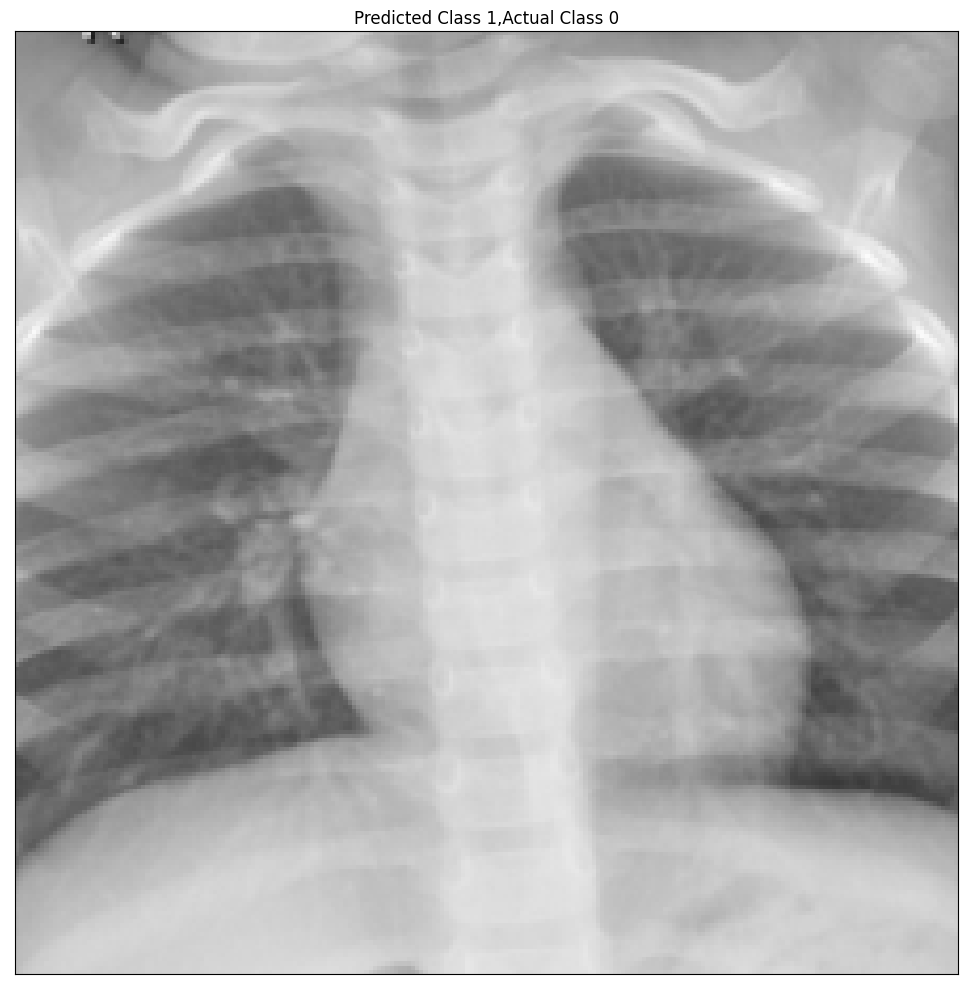

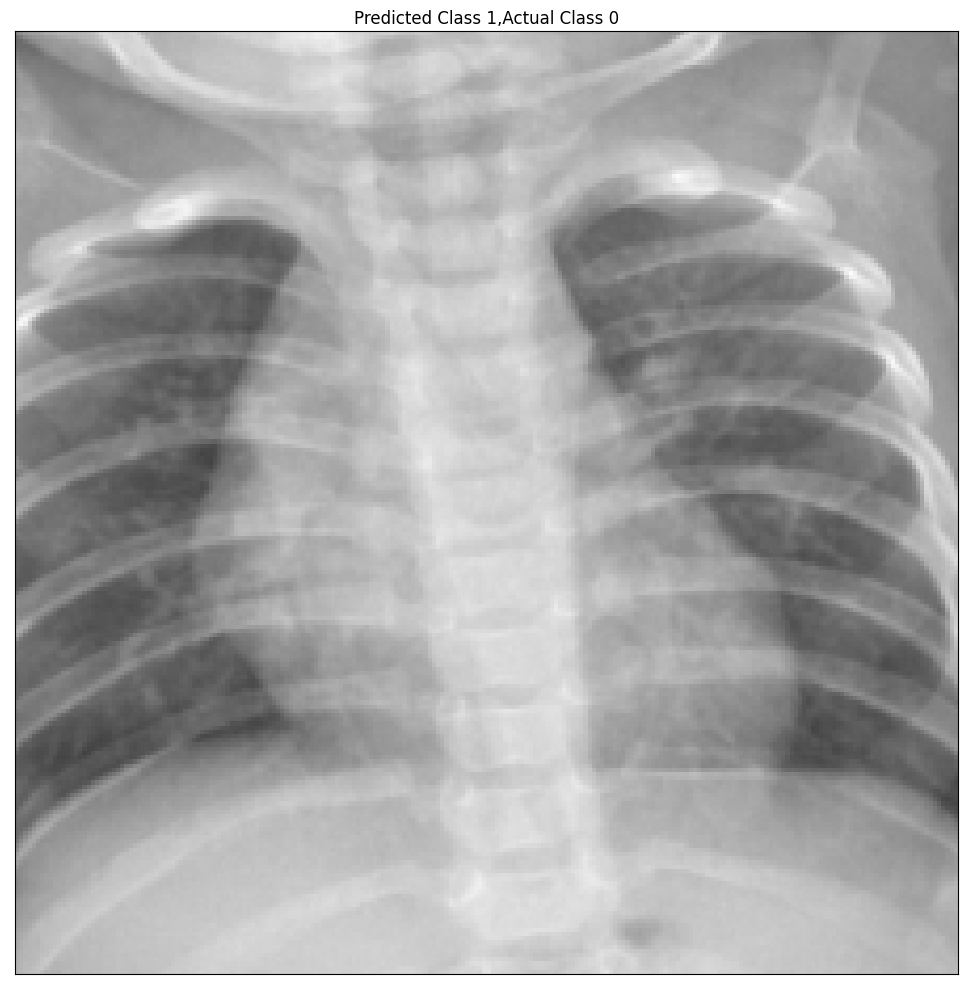

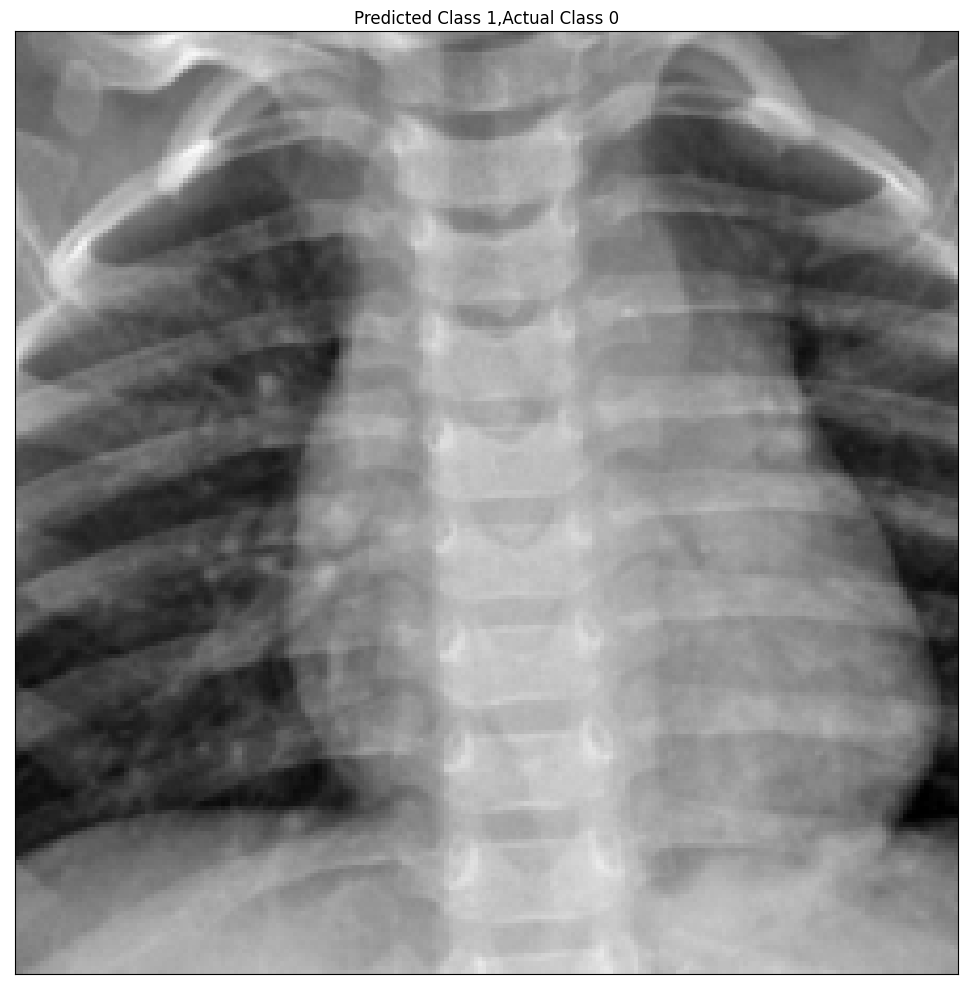

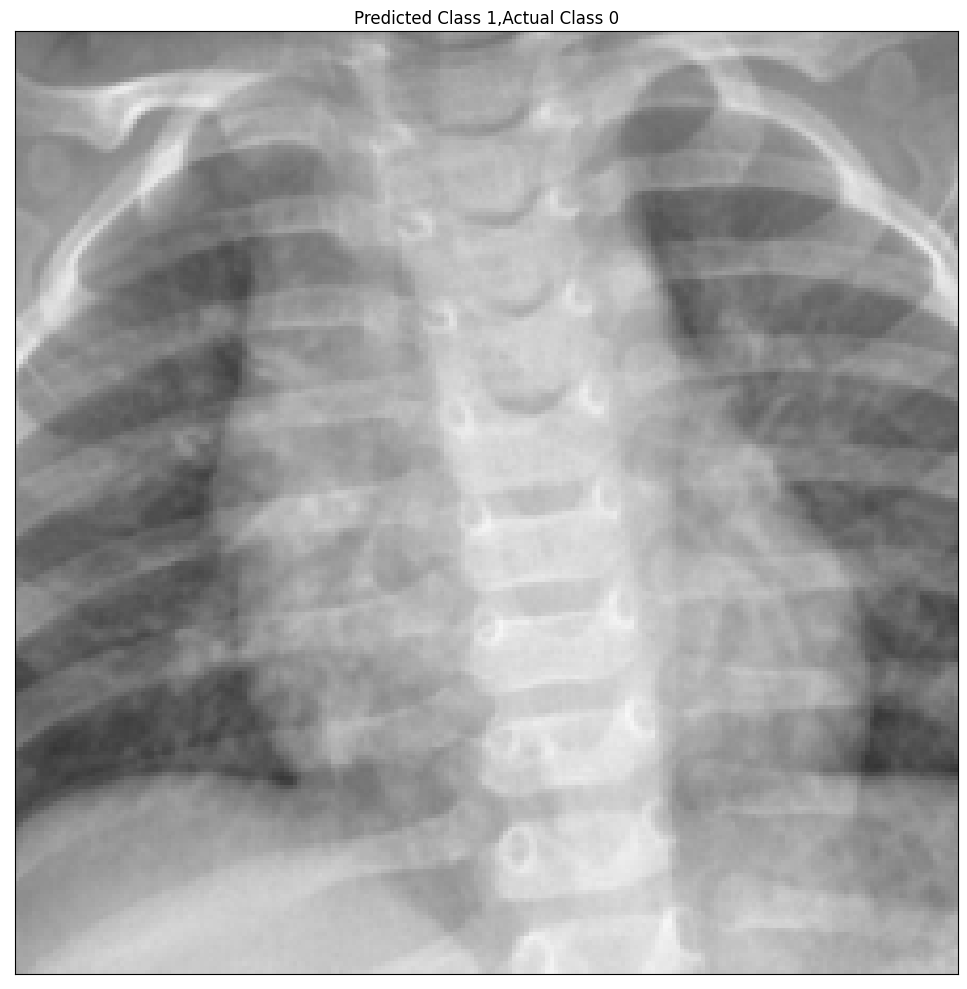

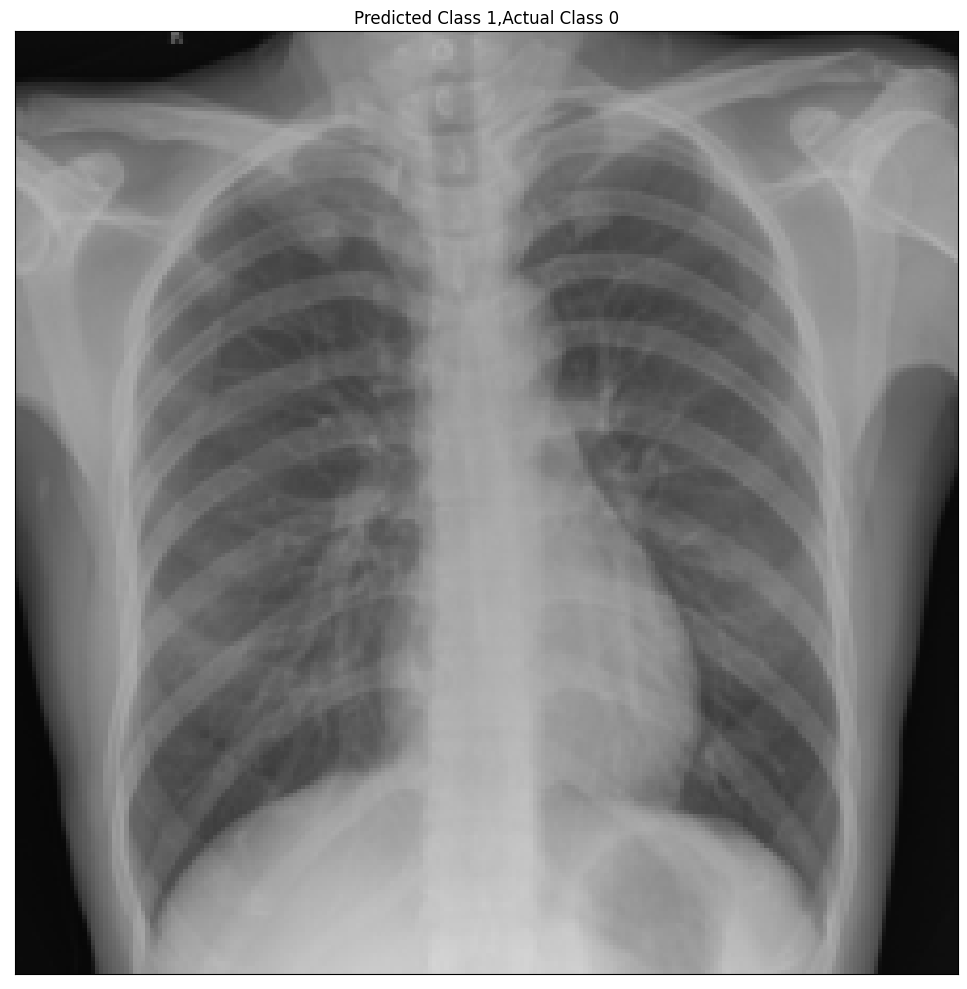

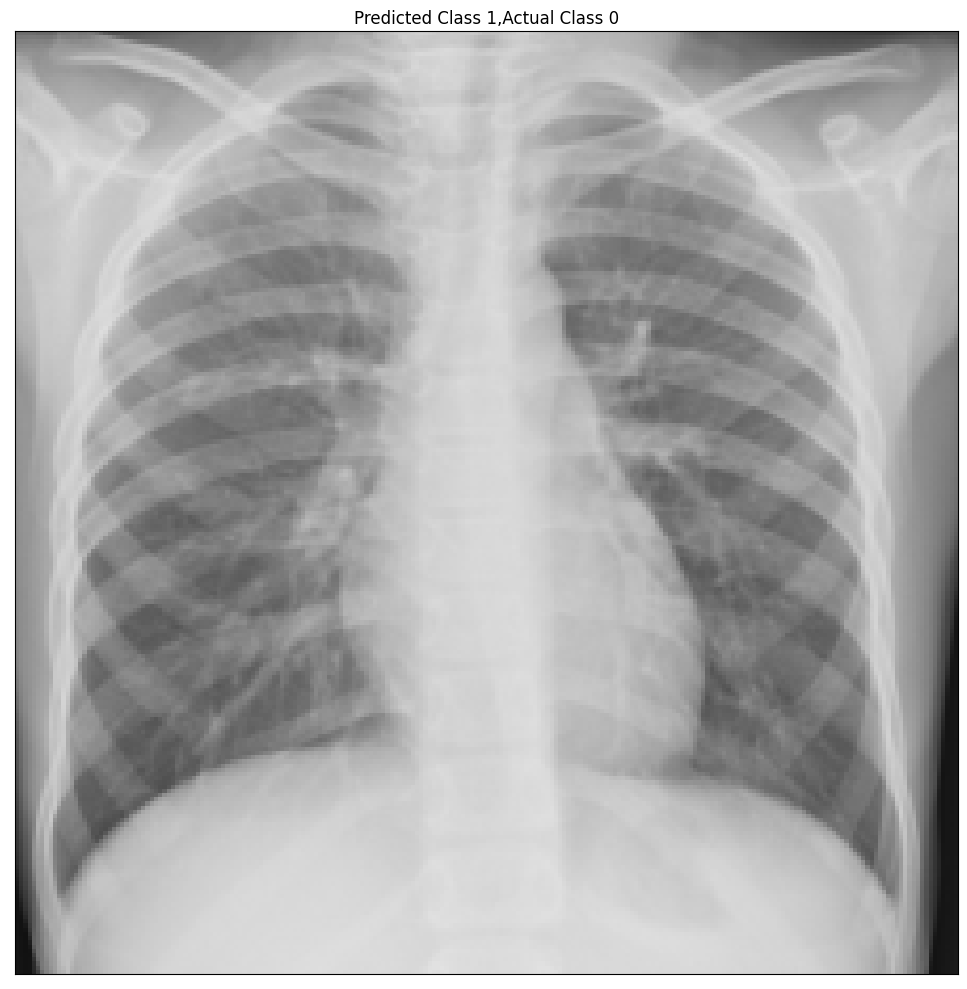

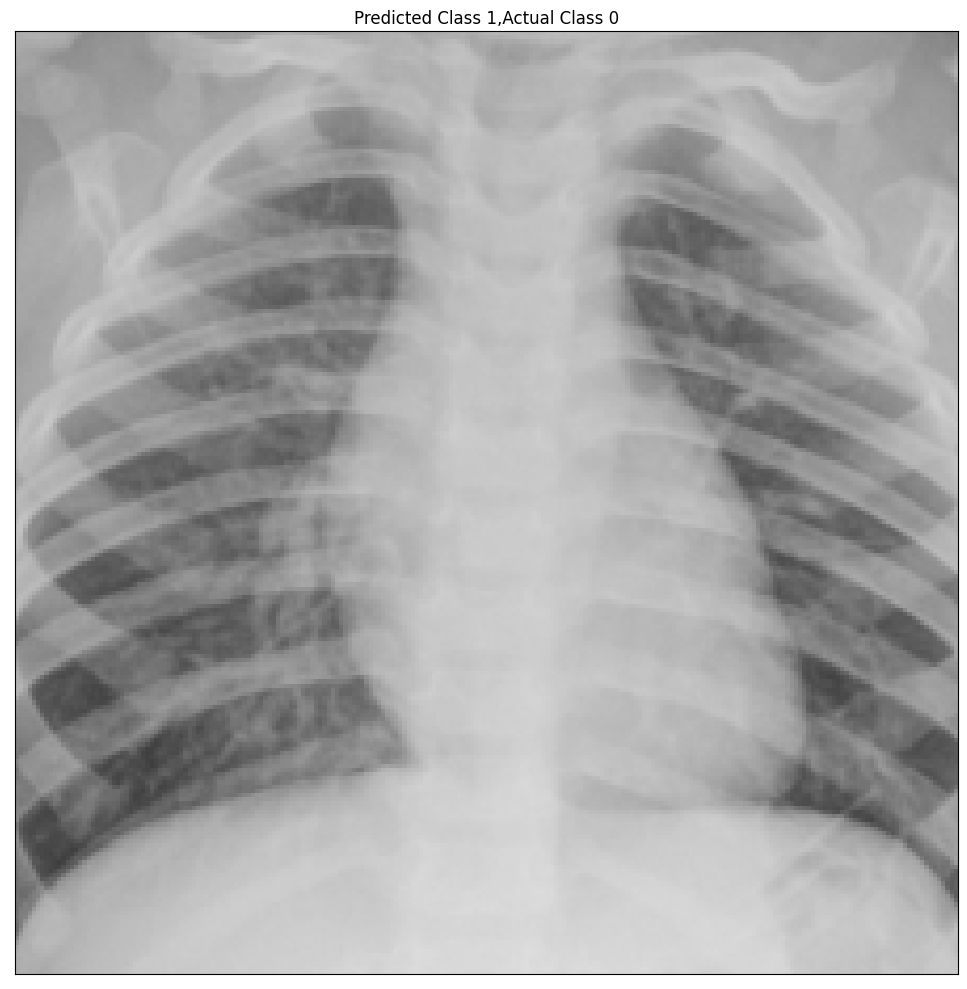

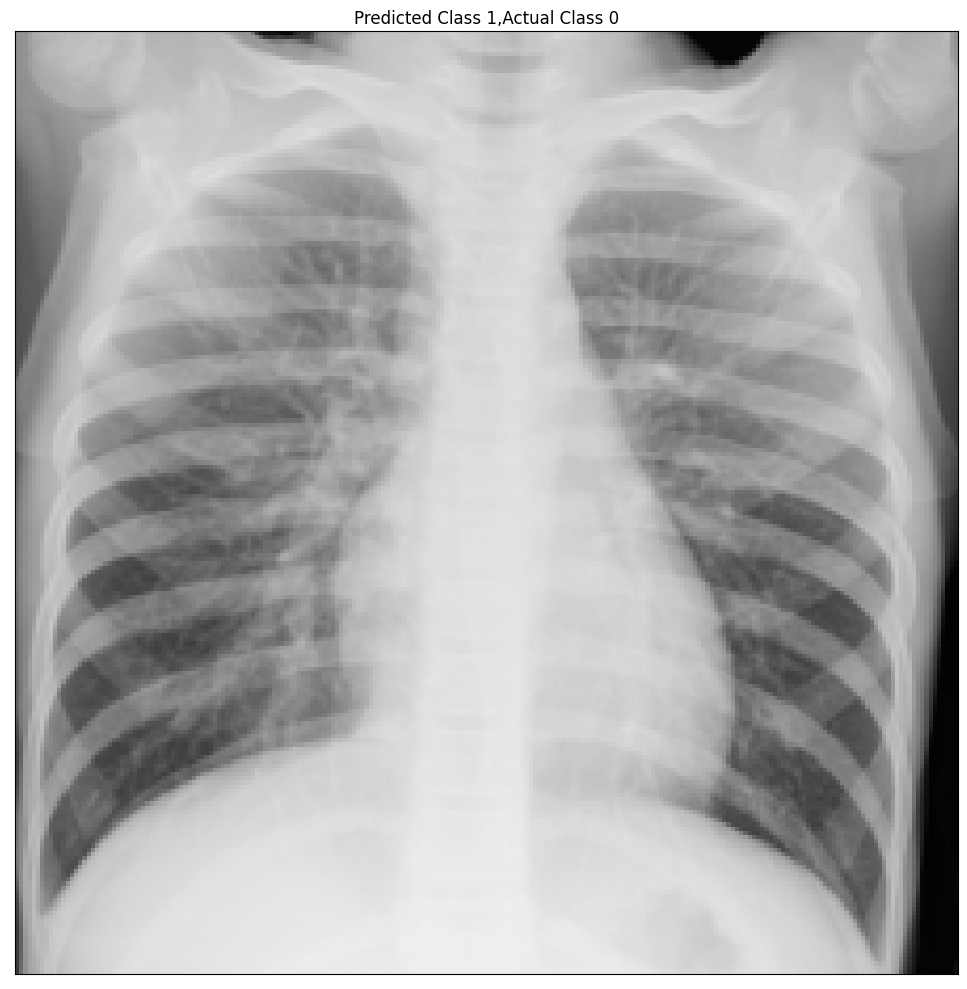

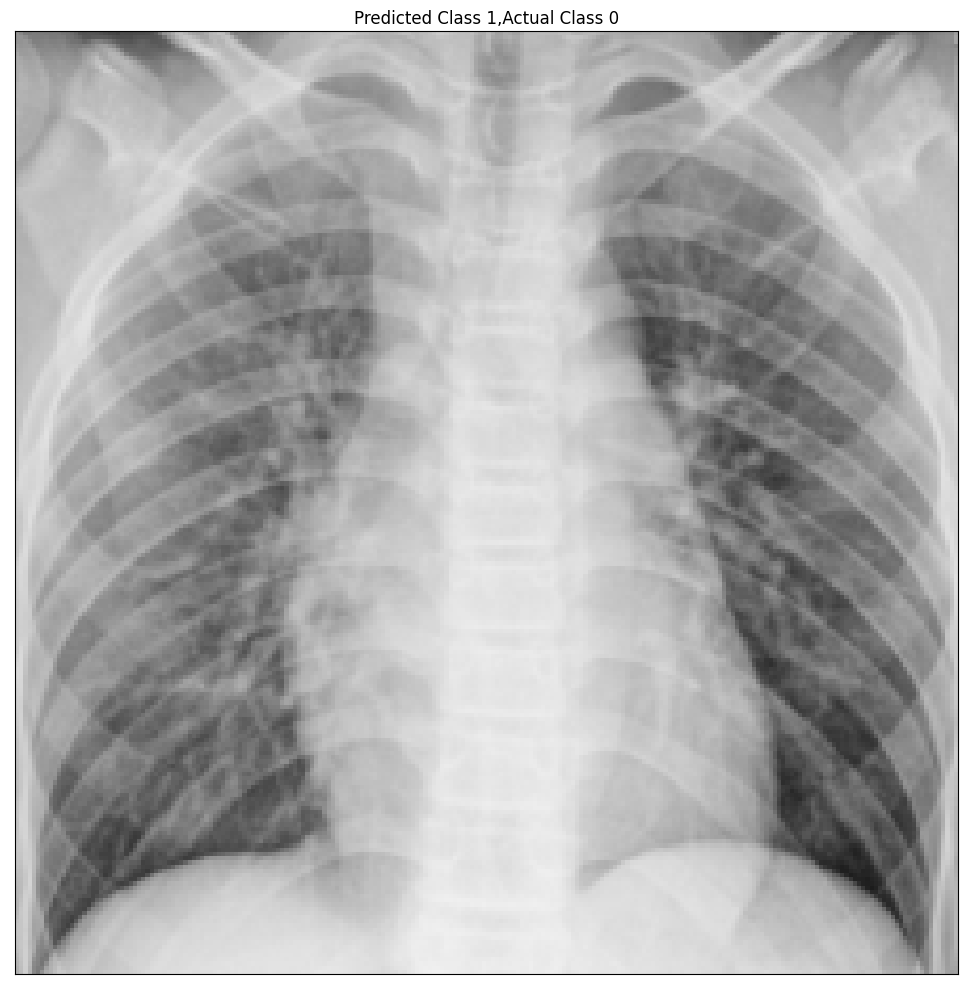

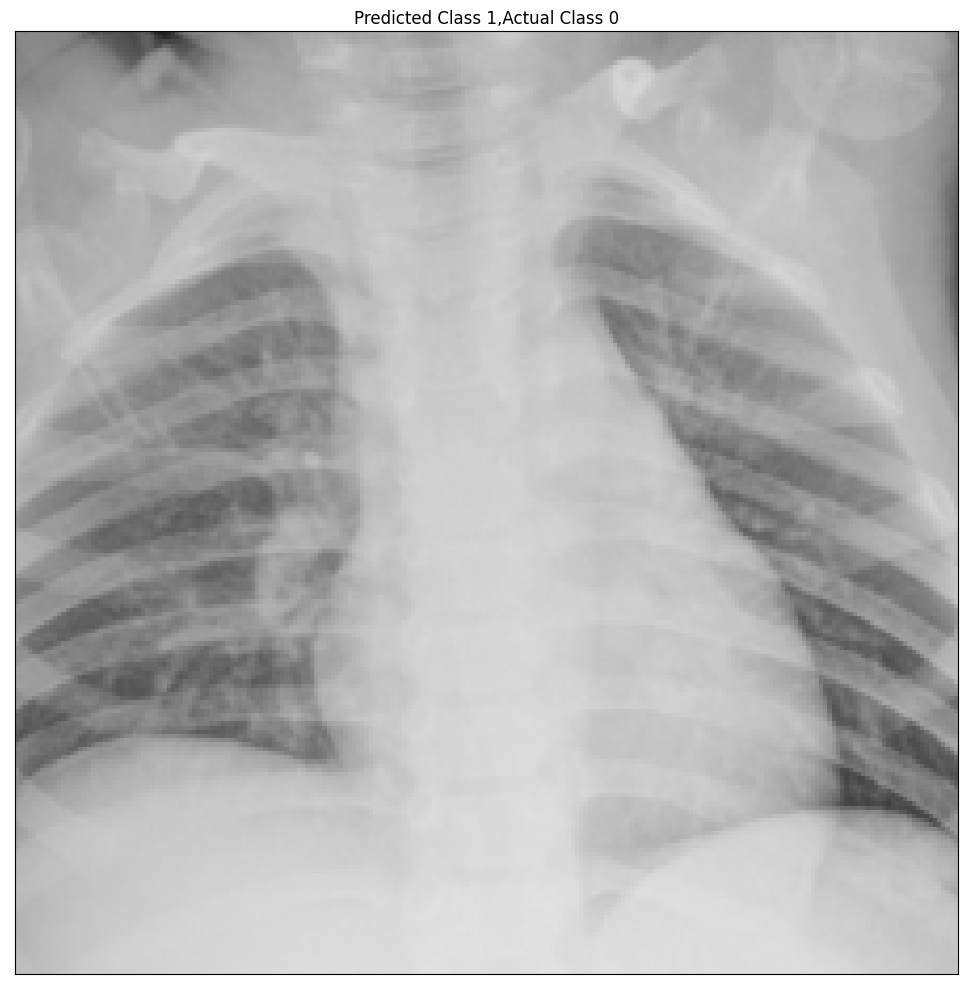

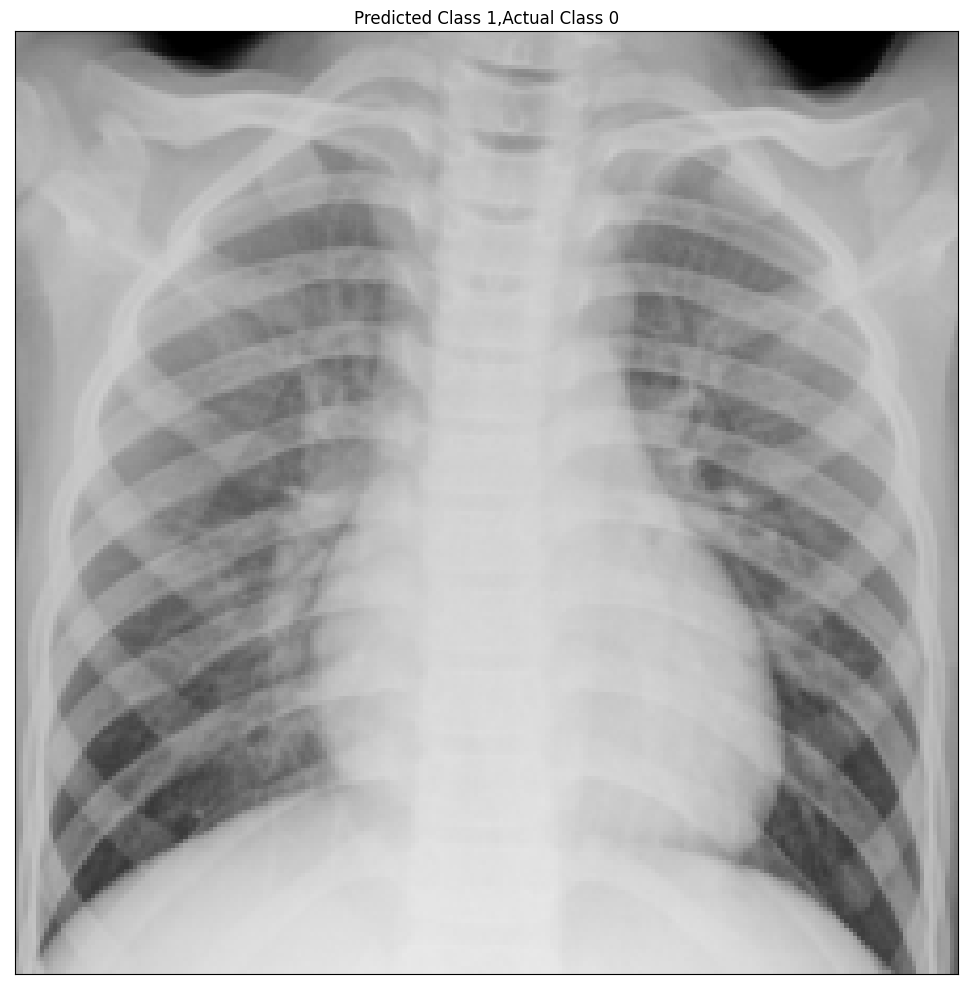

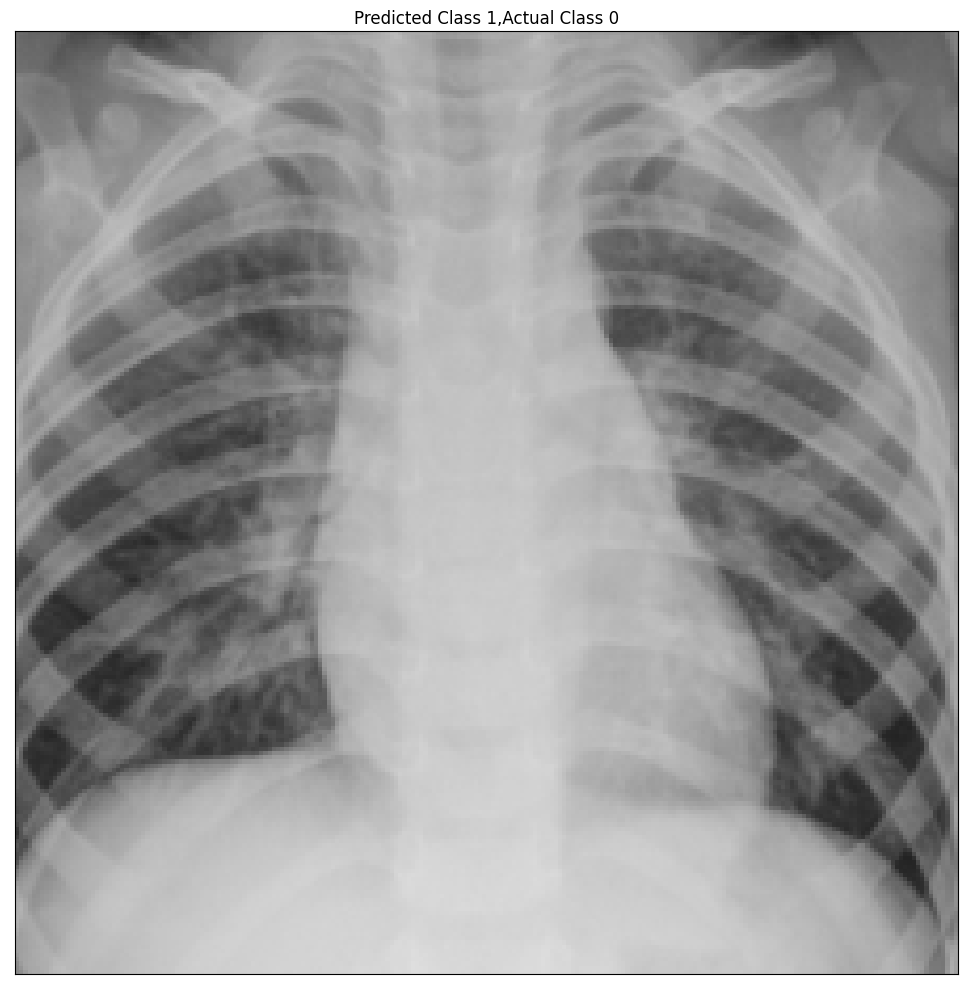

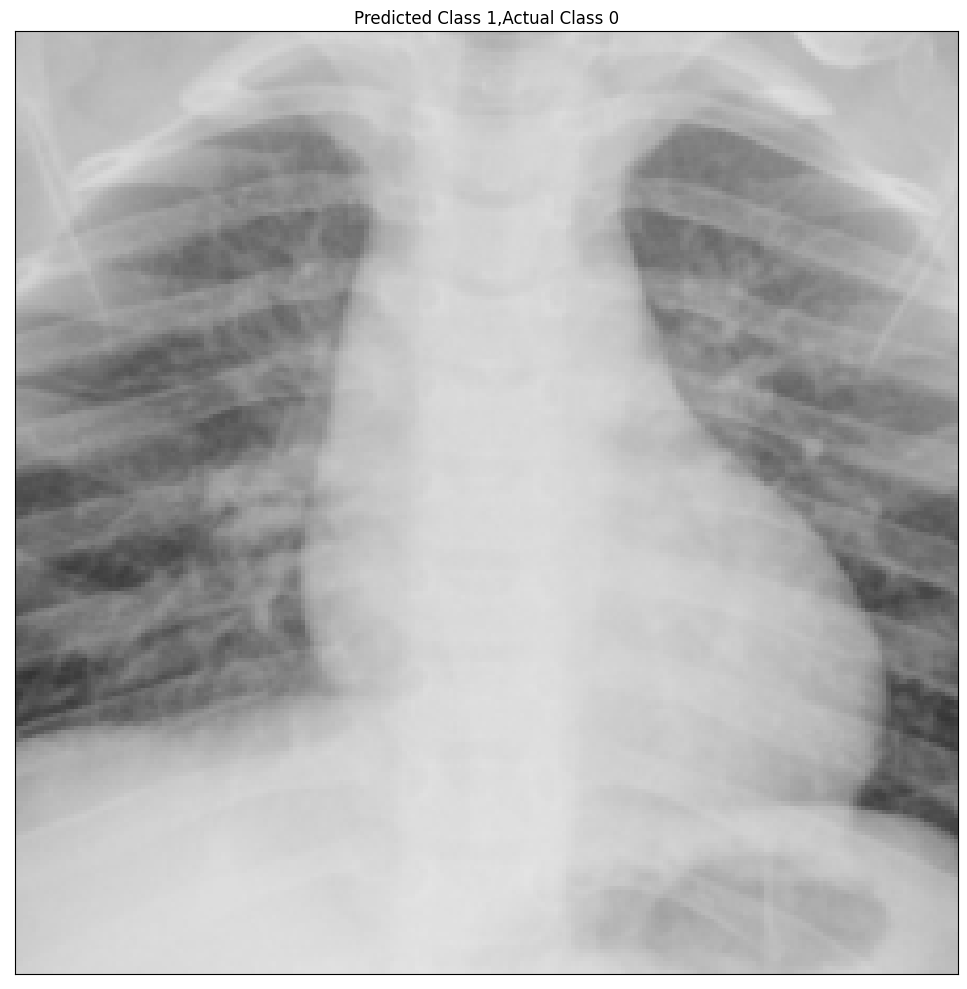

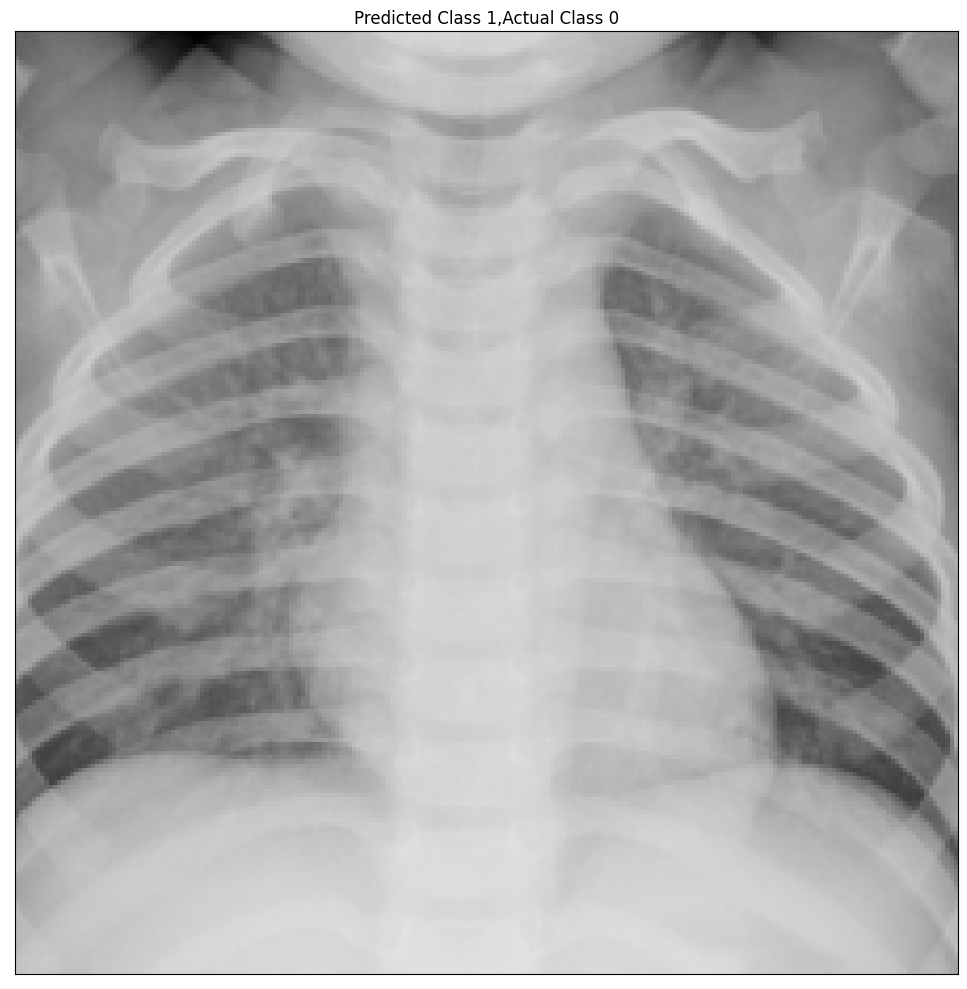

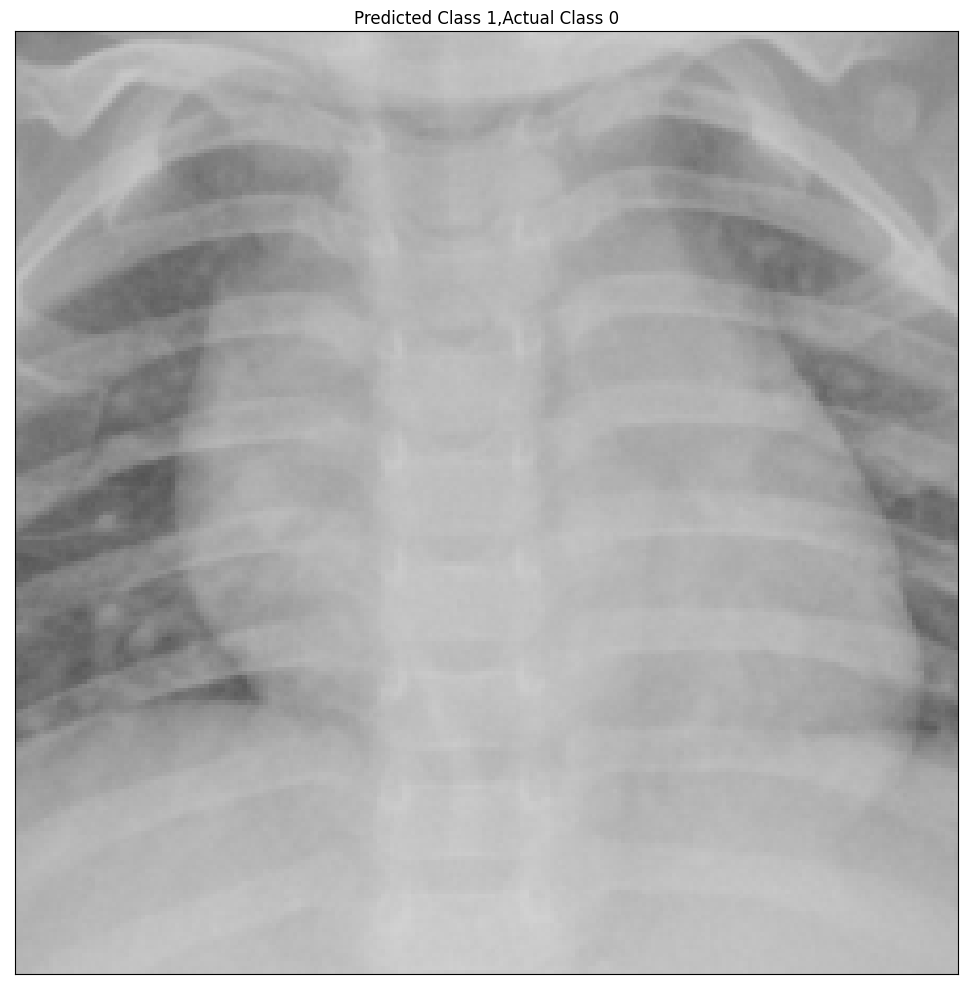

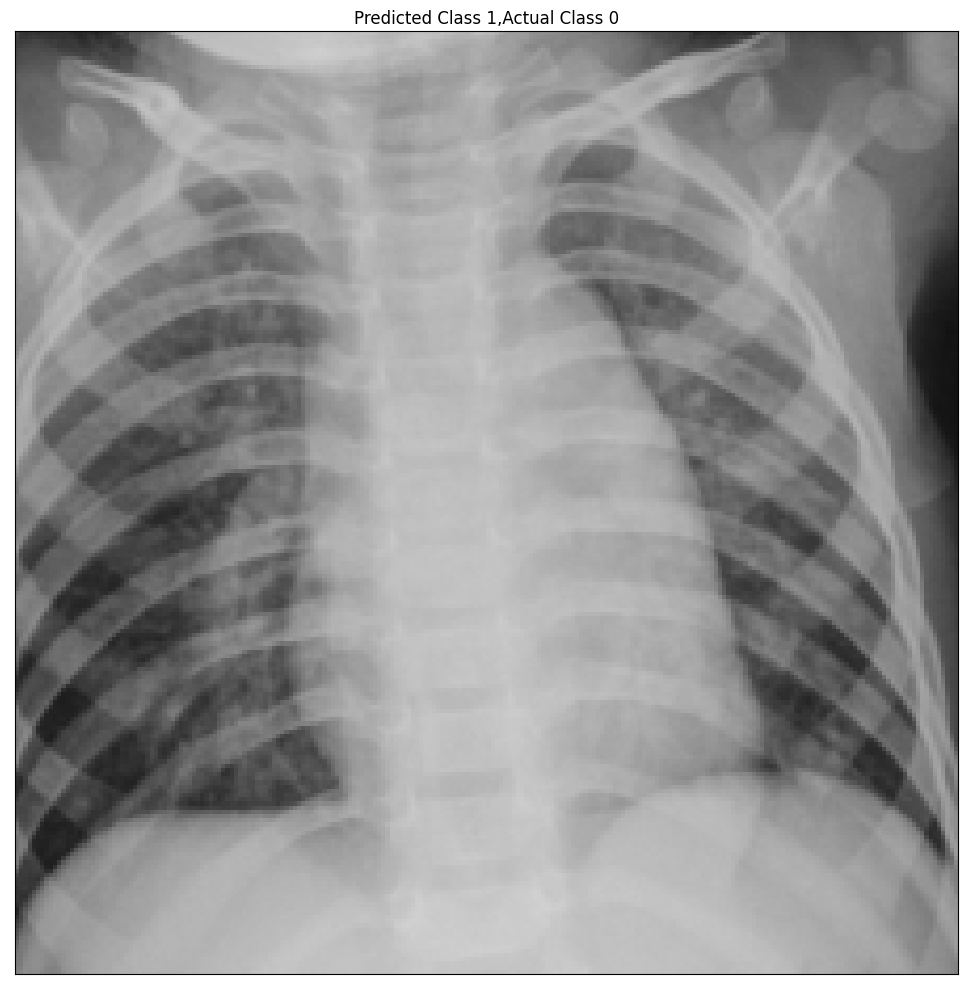

In [ ]:
incorrect_ind = []
for index, (first, second) in enumerate(zip(y_pred, y_true)):
    if first != second:
        incorrect_ind.append(index)
print(len(incorrect_ind))
i = 0
for ind in incorrect_ind[20:40]:
    plt.figure(figsize=(10, 10))
    # plt.subplot(5,3,i+1)
    plt.xticks([])
    plt.yticks([])
    # plt.imshow(x_data[ind].reshape(150,150), cmap="gray", interpolation='none')
    plt.imshow(test_dataset[ind][0].numpy().squeeze().transpose(1, 2, 0))
    plt.title("Predicted Class {},Actual Class {}".format(y_pred[ind], y_true[ind]))
    plt.tight_layout()
    
    i += 1


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd

# test_dataset = ImageFolder(root=test_folder, transform=preprocess)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

y_pred = []
y_true = []
x_data = []
incorrect_images = []

with torch.no_grad():
  model.eval()

  for inputs, labels in test_loader:

    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    probs = model(inputs)
    _, output = torch.max(probs, 1)
    
    output = output.data.cpu().numpy()
    y_pred.extend(output)

    labels = labels.data.cpu().numpy()
    y_true.extend(labels)
    # if output != labels:
    #   incorrect_images.append([inputs,output,labels])


ValueError: ignored

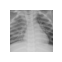

In [ ]:
fig = plt.figure()

ROW_IMG = 10
N_ROWS = 5

for index in range(1, ROW_IMG * N_ROWS + 1):
  plt.subplot(N_ROWS, ROW_IMG, index)
  plt.axis('off')
  plt.imshow(validset[index][0].numpy().squeeze().transpose(1, 2, 0))
  
  with torch.no_grad():
      model.eval()
      probs = model(testset[index][0].cuda().unsqueeze(0))
  title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
  
  plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions')